In [6]:
# [2.2] Setup: import libraries used across dataset loading, DL model, training/eval, and benchmarks
import os
import random
import math
import warnings
from itertools import accumulate
from typing import Optional, List, Tuple
import tqdm

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import PearsonCorrCoef

from einops import rearrange
from einops.layers.torch import Rearrange

from transformers import BertPreTrainedModel
from transformers.modeling_utils import ModuleUtilsMixin
from transformers.models.bert.modeling_bert import (
    BertConfig, 
    BertEmbeddings, 
    BertEncoder, 
    BertLayer, 
    BertAttention
)

In [7]:
# [2.1/2.3] Data pipeline: load EN-selected SNPs, compute LD-gap tokens, build sequences, standardize labels, and create KFold split-based PyTorch Dataset
class DNADataset(Dataset):
    # Updated __init__ to accept ld_threshold
    def __init__(self, data_path, label_path, geno_path, trait, seed, sel_num, ld_threshold=0.8, is_training=True):
        cs = pd.read_csv(f"{data_path}{seed}.csv").sort_values(by='cs', ascending=False)
        Top = sorted(cs.index[:sel_num])  
        Rawgeno = pd.read_csv(geno_path)

        # DROP the first row (SNP index row)
        Rawgeno = Rawgeno.iloc[1:].reset_index(drop=True)

        Top = [i for i in Top if i in Rawgeno.index]

        geno = Rawgeno.loc[Top].copy()

        # explicitly separate columns
        geno_cols = [c for c in geno.columns if c not in ['chrom']]

        LD = self.calculate_LD(geno)
        
        # Pass the variable threshold here
        geno['gap'] = self.assign_gap_labels(LD, ld_threshold)
        
        geno = geno.drop(columns=geno.columns[[-3, -2]])  
        lines = self.generate_geno_sequences(geno)
        annos = pd.read_csv(label_path, index_col=0).iloc[:, [trait]]
        annos = annos.fillna(annos.mean()) 
        annos = StandardScaler().fit_transform(annos).astype(np.float32)

        kfold = KFold(n_splits=5, shuffle=True, random_state=27)
        for i, (train_idx, val_idx) in enumerate(kfold.split(lines, annos)):
            if i == seed:
                train_lines, val_lines = lines[train_idx], lines[val_idx]
                train_annos, val_annos = annos[train_idx], annos[val_idx]                
                break

        train_seqs, train_type_ids = self.process_sequences(train_lines)
        val_seqs, val_type_ids = self.process_sequences(val_lines)

        if is_training:
            self.seqs, self.type_ids, self.annos = train_seqs, train_type_ids, train_annos
        else:
            self.seqs, self.type_ids, self.annos = val_seqs, val_type_ids, val_annos

    def calculate_LD(self, geno):
        geno_values = np.select(
            [geno.iloc[:, :-2].values == 'H', geno.iloc[:, :-2].values == 'M', geno.iloc[:, :-2].values == 'L'],
            [0, 1, 2],
            default=-1
        ) 

        a, b = geno_values[:-1], geno_values[1:]  
        var_a, var_b = np.var(a, axis=1), np.var(b, axis=1)
        mean_a, mean_b = np.mean(a, axis=1), np.mean(b, axis=1)
        d = np.mean((a - mean_a[:, None]) * (b - mean_b[:, None]), axis=1)
        
        LD = np.where((var_a == 0) | (var_b == 0), 0, (d ** 2) / (var_a * var_b))
        LD = np.append(LD, -1)  

        chrom = sorted(set(geno['chrom']))
        index = list(accumulate([len(geno.groupby('chrom').get_group(i)) for i in chrom])) 
        for idx in index:
            LD[idx - 1] = -1        
        return LD

    # Updated to accept threshold parameter
    def assign_gap_labels(self, LD, threshold):
        return np.where(LD == -1, 'N', np.where(LD >= threshold, 'J', 'Y'))

    def generate_geno_sequences(self, geno):
        lines = []
        for i in range(geno.shape[1] - 1):
            geno.iloc[:, i] = geno.iloc[:, i] + geno['gap']
            lines.append(''.join(geno.iloc[:, i]))
        return np.stack(lines, axis=0)

    def process_sequences(self, lines):
        vocabs = {f"{a}{b}": i + 1 for i, (a, b) in enumerate([("H", "J"), ("H", "Y"), ("H", "N"), ("L", "J"), ("L", "Y"), ("L", "N"), ("M", "J"), ("M", "Y"), ("M", "N")])}
        type_vocabs = {"J": 1, "Y": 2, "N": 3}

        seqs, type_ids = [], []
        for raw_seq in lines:
            seq, type_id = [], []
            for i in range(0, len(raw_seq), 2):
                seq.append(vocabs[raw_seq[i:i + 2]])
                type_id.append(type_vocabs[raw_seq[i + 1]])
            seqs.append(seq)
            type_ids.append(type_id)

        return np.asarray(seqs), np.asarray(type_ids)

    def __len__(self):
        return len(self.annos)

    def __getitem__(self, index):
        seq = torch.tensor(self.seqs[index], dtype=torch.float32)
        type_ids = torch.tensor(self.type_ids[index], dtype=torch.float32)
        annos = torch.tensor(self.annos[index], dtype=torch.float32)
        return seq, type_ids, annos

In [8]:
# [2.2] Model definitions: EBMGP architecture + pooling modules (MAP/AVG/MAX/LIP) to support pooling ablation experiments
class soft_pool1d(nn.Module):
    def __init__(self,  kernel_size=2):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride= kernel_size
    def forward(self, x):
        e_x = torch.sum(torch.exp(x),dim=1,keepdim=True)
        return F.avg_pool1d(x.mul(e_x), self.kernel_size, stride=self.stride).mul_(self.kernel_size).div_(F.avg_pool1d(e_x, self.kernel_size, stride=self.stride).mul_(self.kernel_size))

def lip1d(x, logit, kernel=3, stride=2, padding=1):
    weight = logit.exp()
    return F.avg_pool1d(x*weight, kernel, stride, padding)/F.avg_pool1d(weight, kernel, stride, padding)
    
class LIP(nn.Module):
    # Updated to accept pool_size to match AttentionPool's stride/reduction behavior
    def __init__(self, channels, pool_size=2):
        super(LIP, self).__init__()
        self.pool_size = pool_size
        self.logit = nn.Sequential(
                nn.Conv1d(channels, channels, 3, padding=1, bias=False),
                nn.BatchNorm1d(channels, affine=True),
                nn.ReLU(),
        )
    def init_layer(self):
        self.logit[0].weight.data.fill_(0.0)

    def forward(self, x):
        # Pass pool_size as kernel and stride to mimic other pooling layers
        # padding is set to pool_size // 2 to maintain consistency
        frac = lip1d(x, self.logit(x), kernel=self.pool_size, stride=self.pool_size, padding=self.pool_size//2)
        return frac

class AttentionPool(nn.Module):
    def __init__(self, dim, pool_size=2,dropout_prob=0.1):
        super().__init__()
        self.pool_size = pool_size
        self.attn_dropout = nn.Dropout(dropout_prob)
        self.to_attn_logits1 = nn.Conv2d(dim, dim, 1, bias=False)
        self.to_attn_logits2 = nn.ModuleList([nn.Conv1d(dim, dim, 1, bias=False) for _ in range(pool_size)])
        self.BN = nn.BatchNorm1d(dim)
    def forward(self, x):
        b, s, n = x.shape  
        remainder = n % self.pool_size
        needs_padding = remainder > 0      
        if needs_padding:
            x = F.pad(x, (0, (self.pool_size-remainder)), value=0) 
        x = x.unfold(-1,self.pool_size,self.pool_size) 
        outx = []
        i = 0
        for conv in self.to_attn_logits2:                
            nx = x[:,:,:,i]
            nx = self.BN(nx)
            logit = conv(nx)           
            outx.append(logit)
            i+=1 
        outx = torch.stack(outx, dim=-1)       
        logits =  self.to_attn_logits1(outx)
        logits = self.attn_dropout(logits)             
        attn = logits.softmax(dim=-1)             
        outs = (outx * attn).sum(dim=-1)
        return outs
  
class GELU(nn.Module):
    def forward(self, x):
        return torch.sigmoid(1.702 * x) * x
        
def ConvBlock(dim, dimout, kernel_size = 1,stride=2):
    return nn.Sequential(
        nn.BatchNorm1d(dim),
        GELU(),
        nn.Conv1d(dim,  dimout, kernel_size,stride=stride, padding = kernel_size // 2)
    )

class EBMGP(nn.Module):
    def __init__(
        self,
        vocab_size: int = 10,
        type_vocab_size: int = 4,
        hidden_size: int = 64,
        num_layers: int = 1,
        num_attention_heads: int = 8,
        intermediate_size: int = 256,
        hidden_act: str = "gelu",
        dropout_rate: float = 0.3,
        pooling_type: str = "MAP" # New Argument
    ):
        super().__init__()

        self.config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_hidden_layers=num_layers,
            num_attention_heads=num_attention_heads,
            intermediate_size=intermediate_size,
            hidden_act=hidden_act,
            type_vocab_size=type_vocab_size,
            max_position_embeddings=5000, 
            dropout_rate = dropout_rate,
        )

        self.embeddings = BertEmbeddings(self.config)

        # Factory method to select pooling layer
        def get_pool(dim, size):
            if pooling_type == "MAP":
                return AttentionPool(dim, pool_size=size)
            elif pooling_type == "AVG":
                return nn.AvgPool1d(kernel_size=size, stride=size)
            elif pooling_type == "MAX":
                return nn.MaxPool1d(kernel_size=size, stride=size)
            elif pooling_type == "LIP":
                return LIP(dim, pool_size=size)
            else:
                raise ValueError(f"Unknown pooling type: {pooling_type}")

        self.convs = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            ConvBlock(hidden_size, 64,30,stride=2),
            get_pool(64, 1), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 

            nn.BatchNorm1d(64),
            ConvBlock(64, 64, 3,stride=2),            
            get_pool(64, 2), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 

            nn.BatchNorm1d(64),
            ConvBlock(64, 64, 30,stride=2),           
            get_pool(64, 3), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 

            nn.BatchNorm1d(64),
            ConvBlock(64, 64, 3,stride=2),            
            get_pool(64, 2), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 

            nn.BatchNorm1d(64),
            ConvBlock(64, 64, 30,stride=2),           
            get_pool(64, 3), # Replaced hardcoded AttentionPool
            nn.Dropout(dropout_rate), 
        )
          
        self.predictor = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),       
            Rearrange('b c l -> b (c l)'), 
            nn.Linear(64, 1),              
        )

    def forward(
        self,
        input_ids: torch.Tensor,
        token_type_ids: torch.Tensor,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
        output_hidden_states: bool = False,
        return_dict: bool = False,
    ):
        embedding_output = self.embeddings(
            input_ids=input_ids.long(),
            position_ids=position_ids,
            token_type_ids=token_type_ids.long(),
        )
        x = embedding_output.permute(0, 2, 1) 
        x = self.convs(x)
        logits = self.predictor(x) 
        return logits

In [9]:
# [2.3] Training & evaluation: reproducibility seed, epoch loops, metrics (Pearson/RMSE/R2), and a train_and_evaluate wrapper used by experiments

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True


def train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    train_loss = []
    for batch_idx, (seqs, type_ids, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        seqs, type_ids, labels = seqs.to(device), type_ids.to(device), labels.to(device)
        predict = model(seqs, type_ids)
        loss = loss_fn(predict, labels)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
    return np.mean(train_loss)


def evaluate_epoch(model, test_loader, loss_fn, pearson, device):
    model.eval()
    valid_loss = []
    vp, vt = [], []
    with torch.no_grad():
        for seqs, type_ids, labels in test_loader:
            seqs, type_ids, labels = seqs.to(device), type_ids.to(device), labels.to(device)
            pred = model(seqs, type_ids)
            val_loss = loss_fn(pred, labels)
            valid_loss.append(val_loss.item())
            vp.extend(pred.squeeze().cpu().numpy())
            vt.extend(labels.squeeze().cpu().numpy())
    return np.mean(valid_loss), vp, vt

from sklearn.metrics import r2_score

# Added pooling_type argument
def train_and_evaluate(trait, data_path, label_path, geno_path, device, learning_rate, epochs, seed, sel_num, ld_threshold=0.8, pooling_type="MAP"):
    setup_seed(3407)

    loss_fn = nn.L1Loss()
    bs = 32
    
    # Dataset init (reusing your existing modified Dataset class)
    traindataset = DNADataset(data_path, label_path, geno_path, trait, seed, sel_num, ld_threshold=ld_threshold, is_training=True)
    testdataset = DNADataset(data_path, label_path, geno_path, trait, seed, sel_num, ld_threshold=ld_threshold, is_training=False)

    train_loader = DataLoader(traindataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(testdataset, batch_size=bs, shuffle=False)

    print(f"Seed {seed} | Pool {pooling_type} | Train Samples: {len(traindataset)} | Test Samples: {len(testdataset)}")

    # Initialize model with pooling_type
    model = EBMGP(pooling_type=pooling_type).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    steps = math.ceil(len(traindataset) / bs) * epochs - 1
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)
    pearson = PearsonCorrCoef().to(device)

    corrs, RMSE, pred, obser = [], [], [], []
    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)
        
        if epoch == epochs:
            valid_loss, vp, vt = evaluate_epoch(model, test_loader, loss_fn, pearson, device)
            
            valMSE = mean_squared_error(vp, vt)
            val_r2 = r2_score(vt, vp) 
            v_corr = pearson(torch.tensor(vp).to(device), torch.tensor(vt).to(device))
            
            print(f"   > Final Train Loss: {train_loss:.4f} | Final Val Loss: {valid_loss:.4f}")
            print(f"   > R2 Score: {val_r2:.4f} | Corr: {v_corr.item():.4f}")
            print("-" * 40)
            
            RMSE.append(valMSE)
            corrs.append(v_corr.item())
            pred.extend(vp)
            obser.extend(vt)
            
    return np.mean(corrs), np.mean(RMSE), pred, obser

In [10]:
# [3] Ablation study pipeline: (1) LD threshold sweep and (2) pooling strategy sweep; trains EBMGP across seeds/species/traits and saves mean metrics to JSON

import torch
import numpy as np
import os
import json

# --- Configuration ---
learning_rate = 0.0005
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Optimal Feature Counts per Species (Used for both ablations)
species_optimal_counts = {
    "rice": 5000,
    "sorghum": 5000,
    # "soybean": 3000,
    "bulls": 5000
}

species_config = {
    "rice": {
        "label_path": "./data/rice_pheno.csv",
        "geno_path": "./data/ricerawgeno.csv",
        "traits": ['SW', 'FLW', 'AC', 'PH', 'SNPP']
    },
    "sorghum": {
        "label_path": "./data/sorghum_pheno.csv",
        "geno_path": "./data/sorghumrawgeno.csv",
        "traits": ['HT', 'MO', 'YLD']
    },
    # "soybean": {
    #     "label_path": "./data/soybean_pheno.csv",
    #     "geno_path": "./data/soybeanrawgeno.csv",
    #     "traits": ['protein', 'Steartic', 'R8', 'SdWgt', 'Yield']
    # },
    "bulls": {
        "label_path": "./data/bulls_pheno.csv",
        "geno_path": "./data/bullsrawgeno.csv",
        "traits": ['MS', 'NMSP', 'VE']
    }
}

# --- Experiment 1: LD Threshold Ablation ---
def run_ld_ablation():
    print("\n" + "#"*60)
    print("RUNNING EXPERIMENT: LD THRESHOLD ABLATION")
    print("#"*60)
    
    ld_thresholds = [0.2, 0.4, 0.6, 0.8]
    
    for species, optimal_count in species_optimal_counts.items():
        config = species_config[species]
        sel_num = optimal_count
        T_folder = f"T{optimal_count}"
        
        for ld_thresh in ld_thresholds:
            print(f"\n   >>> Processing LD Threshold: {ld_thresh} | Species: {species} | Feature Count: {T_folder}")
            
            results_data = {
                "species": species,
                "feature_count": optimal_count,
                "ld_threshold": ld_thresh,
                "pooling_type": "MAP", # Default for LD ablation
                "mean_corrs": {},
                "mean_RMSE": {}
            }

            for trait_idx, trait_name in enumerate(config["traits"]):
                data_path = f"./EN/{species}/{T_folder}{trait_name}"
                
                if not os.path.exists(f"{data_path}0.csv"):
                    continue

                corrs, RMSE = [], []
                print(f"      Processing Trait: {trait_name}")
                
                for seed in range(5):
                    try:
                        # Uses default pooling_type="MAP"
                        fold_corrs, fold_RMSE, _, _ = train_and_evaluate(
                            trait_idx, data_path, config["label_path"], config["geno_path"], 
                            device, learning_rate, epochs, seed, sel_num,
                            ld_threshold=ld_thresh, pooling_type="MAP"
                        )
                        corrs.append(fold_corrs)
                        RMSE.append(fold_RMSE)
                    except Exception as e:
                        print(f"         [Error] Seed {seed}: {e}")

                if corrs:
                    results_data["mean_corrs"][trait_name] = float(np.mean(corrs))
                    results_data["mean_RMSE"][trait_name] = float(np.mean(RMSE))

            # Save JSON
            json_filename = f"{species}_{T_folder}_LD{ld_thresh}.json"
            with open(json_filename, "w") as f:
                json.dump(results_data, f, indent=4)
            print(f"   [Saved] {json_filename}")


# --- Experiment 2: Pooling Strategy Ablation ---
def run_pooling_ablation():
    print("\n" + "#"*60)
    print("RUNNING EXPERIMENT: POOLING STRATEGY ABLATION")
    print("#"*60)
    
    pooling_types = ["MAP", "AVG", "MAX", "LIP"]
    
    for species, optimal_count in species_optimal_counts.items():
        config = species_config[species]
        sel_num = optimal_count
        T_folder = f"T{optimal_count}"
        
        for p_type in pooling_types:
            print(f"\n   >>> Processing Pooling Type: {p_type} | Species: {species} | Feature Count: {T_folder}")
            
            results_data = {
                "species": species,
                "feature_count": optimal_count,
                "ld_threshold": 0.8, # Default for Pooling ablation
                "pooling_type": p_type,
                "mean_corrs": {},
                "mean_RMSE": {}
            }

            for trait_idx, trait_name in enumerate(config["traits"]):
                data_path = f"./EN/{species}/{T_folder}{trait_name}"
                
                if not os.path.exists(f"{data_path}0.csv"):
                    continue

                corrs, RMSE = [], []
                print(f"      Processing Trait: {trait_name}")
                
                for seed in range(5):
                    try:
                        # Uses default ld_threshold=0.8
                        fold_corrs, fold_RMSE, _, _ = train_and_evaluate(
                            trait_idx, data_path, config["label_path"], config["geno_path"], 
                            device, learning_rate, epochs, seed, sel_num,
                            ld_threshold=0.8, pooling_type=p_type
                        )
                        corrs.append(fold_corrs)
                        RMSE.append(fold_RMSE)
                    except Exception as e:
                        print(f"         [Error] Seed {seed}: {e}")

                if corrs:
                    results_data["mean_corrs"][trait_name] = float(np.mean(corrs))
                    results_data["mean_RMSE"][trait_name] = float(np.mean(RMSE))

            # Save JSON
            json_filename = f"{species}_{T_folder}_{p_type}.json"
            with open(json_filename, "w") as f:
                json.dump(results_data, f, indent=4)
            print(f"   [Saved] {json_filename}")

def main():
    # You can comment out one of these lines if you only want to run one experiment
    run_ld_ablation()
    run_pooling_ablation()

if __name__ == "__main__":
    main()


############################################################
RUNNING EXPERIMENT: LD THRESHOLD ABLATION
############################################################

   >>> Processing LD Threshold: 0.2 | Species: rice | Feature Count: T5000
      Processing Trait: SW
Seed 0 | Pool MAP | Train Samples: 330 | Test Samples: 83
   > Final Train Loss: 0.4055 | Final Val Loss: 0.5361
   > R2 Score: 0.2691 | Corr: 0.5834
----------------------------------------
Seed 1 | Pool MAP | Train Samples: 330 | Test Samples: 83
   > Final Train Loss: 0.3943 | Final Val Loss: 0.5843
   > R2 Score: 0.3154 | Corr: 0.5968
----------------------------------------
Seed 2 | Pool MAP | Train Samples: 330 | Test Samples: 83
   > Final Train Loss: 0.3622 | Final Val Loss: 0.6269
   > R2 Score: 0.3619 | Corr: 0.6520
----------------------------------------
Seed 3 | Pool MAP | Train Samples: 331 | Test Samples: 82
   > Final Train Loss: 0.4369 | Final Val Loss: 0.5768
   > R2 Score: 0.1582 | Corr: 0.4640
---------

/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2737 | Final Val Loss: 0.6440
   > R2 Score: 0.1950 | Corr: 0.5240
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2516 | Final Val Loss: 0.6915
   > R2 Score: 0.2032 | Corr: 0.4957
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2589 | Final Val Loss: 0.6334
   > R2 Score: 0.3030 | Corr: 0.5549
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2572 | Final Val Loss: 0.6780
   > R2 Score: 0.2810 | Corr: 0.5360
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2803 | Final Val Loss: 0.6569
   > R2 Score: 0.2958 | Corr: 0.5554
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2968 | Final Val Loss: 0.8285
   > R2 Score: 0.0062 | Corr: 0.2331
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2762 | Final Val Loss: 0.6452
   > R2 Score: 0.0754 | Corr: 0.3613
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2986 | Final Val Loss: 0.6832
   > R2 Score: 0.0226 | Corr: 0.3513
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3209 | Final Val Loss: 0.7226
   > R2 Score: -0.0199 | Corr: 0.3411
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2948 | Final Val Loss: 0.7777
   > R2 Score: 0.2315 | Corr: 0.4929
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2653 | Final Val Loss: 0.6458
   > R2 Score: 0.3617 | Corr: 0.6023
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2670 | Final Val Loss: 0.7250
   > R2 Score: 0.2407 | Corr: 0.5218
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2713 | Final Val Loss: 0.6867
   > R2 Score: 0.2743 | Corr: 0.5746
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2740 | Final Val Loss: 0.6153
   > R2 Score: 0.2841 | Corr: 0.5800
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2482 | Final Val Loss: 0.6831
   > R2 Score: 0.2397 | Corr: 0.5167
----------------------------------------
   [Saved] sorghum_T5000_LD0.2.json

   >>> Processing LD Threshold: 0.4 | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2578 | Final Val Loss: 0.6517
   > R2 Score: 0.1835 | Corr: 0.4945
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2400 | Final Val Loss: 0.6868
   > R2 Score: 0.2002 | Corr: 0.5247
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2709 | Final Val Loss: 0.6170
   > R2 Score: 0.3120 | Corr: 0.5765
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2691 | Final Val Loss: 0.7384
   > R2 Score: 0.1406 | Corr: 0.4640
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2712 | Final Val Loss: 0.6476
   > R2 Score: 0.3349 | Corr: 0.5839
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2944 | Final Val Loss: 0.8027
   > R2 Score: 0.0674 | Corr: 0.2972
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2864 | Final Val Loss: 0.6410
   > R2 Score: 0.1213 | Corr: 0.3884
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2777 | Final Val Loss: 0.6794
   > R2 Score: 0.0453 | Corr: 0.3548
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3131 | Final Val Loss: 0.7374
   > R2 Score: -0.0645 | Corr: 0.2715
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3021 | Final Val Loss: 0.7556
   > R2 Score: 0.2373 | Corr: 0.4923
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2659 | Final Val Loss: 0.6539
   > R2 Score: 0.3008 | Corr: 0.5929
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2675 | Final Val Loss: 0.7075
   > R2 Score: 0.3099 | Corr: 0.5647
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2715 | Final Val Loss: 0.7068
   > R2 Score: 0.2375 | Corr: 0.5711
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2582 | Final Val Loss: 0.5815
   > R2 Score: 0.3258 | Corr: 0.5981
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2623 | Final Val Loss: 0.6632
   > R2 Score: 0.2629 | Corr: 0.5472
----------------------------------------
   [Saved] sorghum_T5000_LD0.4.json

   >>> Processing LD Threshold: 0.6 | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2547 | Final Val Loss: 0.6317
   > R2 Score: 0.2561 | Corr: 0.5284
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2428 | Final Val Loss: 0.6837
   > R2 Score: 0.1990 | Corr: 0.5156
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2729 | Final Val Loss: 0.5780
   > R2 Score: 0.3649 | Corr: 0.6098
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2376 | Final Val Loss: 0.7254
   > R2 Score: 0.2104 | Corr: 0.4999
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2593 | Final Val Loss: 0.6552
   > R2 Score: 0.2753 | Corr: 0.5375
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2915 | Final Val Loss: 0.8126
   > R2 Score: 0.0201 | Corr: 0.2540
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2648 | Final Val Loss: 0.6653
   > R2 Score: 0.1257 | Corr: 0.4637
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2765 | Final Val Loss: 0.6626
   > R2 Score: 0.0968 | Corr: 0.3960
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3085 | Final Val Loss: 0.7352
   > R2 Score: 0.0038 | Corr: 0.3263
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2814 | Final Val Loss: 0.8344
   > R2 Score: 0.1333 | Corr: 0.4261
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2789 | Final Val Loss: 0.6467
   > R2 Score: 0.3415 | Corr: 0.5857
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2766 | Final Val Loss: 0.7121
   > R2 Score: 0.3061 | Corr: 0.5591
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2630 | Final Val Loss: 0.7009
   > R2 Score: 0.2515 | Corr: 0.5739
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2728 | Final Val Loss: 0.6194
   > R2 Score: 0.2402 | Corr: 0.6011
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2695 | Final Val Loss: 0.6898
   > R2 Score: 0.2098 | Corr: 0.5263
----------------------------------------
   [Saved] sorghum_T5000_LD0.6.json

   >>> Processing LD Threshold: 0.8 | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2434 | Final Val Loss: 0.6504
   > R2 Score: 0.1906 | Corr: 0.4949
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2559 | Final Val Loss: 0.6951
   > R2 Score: 0.2177 | Corr: 0.5080
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2781 | Final Val Loss: 0.6064
   > R2 Score: 0.3069 | Corr: 0.5619
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2585 | Final Val Loss: 0.6984
   > R2 Score: 0.2637 | Corr: 0.5356
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2626 | Final Val Loss: 0.6697
   > R2 Score: 0.2687 | Corr: 0.5562
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2850 | Final Val Loss: 0.8147
   > R2 Score: 0.0397 | Corr: 0.2826
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2651 | Final Val Loss: 0.6188
   > R2 Score: 0.1304 | Corr: 0.3882
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2982 | Final Val Loss: 0.6969
   > R2 Score: 0.0072 | Corr: 0.3947
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3052 | Final Val Loss: 0.7501
   > R2 Score: -0.0674 | Corr: 0.3254
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2825 | Final Val Loss: 0.7743
   > R2 Score: 0.2086 | Corr: 0.4826
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2855 | Final Val Loss: 0.6863
   > R2 Score: 0.2661 | Corr: 0.5414
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2506 | Final Val Loss: 0.7172
   > R2 Score: 0.2881 | Corr: 0.5424
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2500 | Final Val Loss: 0.6652
   > R2 Score: 0.3379 | Corr: 0.5895
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2689 | Final Val Loss: 0.6228
   > R2 Score: 0.2761 | Corr: 0.5797
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2503 | Final Val Loss: 0.6354
   > R2 Score: 0.2922 | Corr: 0.5496
----------------------------------------
   [Saved] sorghum_T5000_LD0.8.json

   >>> Processing LD Threshold: 0.2 | Species: bulls | Feature Count: T5000
      Processing Trait: MS
Seed 0 | Pool MAP | Train Samples: 1206 | Test Samples: 302
   > Final Train Loss: 0.2514 | Final Val Loss: 0.7584
   > R2 Score: 0.0898 | Corr: 0.3803
----------------------------------------
Seed 1 | Pool MAP | Train Samples: 1206 | Test Samples: 302
   > Final Train Loss: 0.3017 | Final Val Loss: 0.6725
   > R2 Score: 0.2007 | Corr: 0.4757
----------------------------------------
Seed 2 | Pool MAP | Train Samples: 1206 | Test Samples: 302
   > Final Train Loss: 0.2543 | Final Val Loss: 0.7272
   > R2 Score: 0.0968 | Corr: 0.3859
----------------------------------------
Seed 3 | Pool MAP | Train Samples: 1207 | Test Samples: 301
   > Final Train Loss: 0.2651 

/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2434 | Final Val Loss: 0.6504
   > R2 Score: 0.1906 | Corr: 0.4949
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2559 | Final Val Loss: 0.6951
   > R2 Score: 0.2177 | Corr: 0.5080
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2781 | Final Val Loss: 0.6064
   > R2 Score: 0.3069 | Corr: 0.5619
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2585 | Final Val Loss: 0.6984
   > R2 Score: 0.2637 | Corr: 0.5356
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2626 | Final Val Loss: 0.6697
   > R2 Score: 0.2687 | Corr: 0.5562
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2850 | Final Val Loss: 0.8147
   > R2 Score: 0.0397 | Corr: 0.2826
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2651 | Final Val Loss: 0.6188
   > R2 Score: 0.1304 | Corr: 0.3882
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2982 | Final Val Loss: 0.6969
   > R2 Score: 0.0072 | Corr: 0.3947
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3052 | Final Val Loss: 0.7501
   > R2 Score: -0.0674 | Corr: 0.3254
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2825 | Final Val Loss: 0.7743
   > R2 Score: 0.2086 | Corr: 0.4826
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2855 | Final Val Loss: 0.6863
   > R2 Score: 0.2661 | Corr: 0.5414
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2506 | Final Val Loss: 0.7172
   > R2 Score: 0.2881 | Corr: 0.5424
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2500 | Final Val Loss: 0.6652
   > R2 Score: 0.3379 | Corr: 0.5895
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2689 | Final Val Loss: 0.6228
   > R2 Score: 0.2761 | Corr: 0.5797
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2503 | Final Val Loss: 0.6354
   > R2 Score: 0.2922 | Corr: 0.5496
----------------------------------------
   [Saved] sorghum_T5000_MAP.json

   >>> Processing Pooling Type: AVG | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool AVG | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2278 | Final Val Loss: 0.6294
   > R2 Score: 0.2246 | Corr: 0.5378
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2416 | Final Val Loss: 0.6776
   > R2 Score: 0.2235 | Corr: 0.5344
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2450 | Final Val Loss: 0.6891
   > R2 Score: 0.2040 | Corr: 0.5280
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2299 | Final Val Loss: 0.7890
   > R2 Score: 0.0257 | Corr: 0.4584
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2696 | Final Val Loss: 0.6799
   > R2 Score: 0.2144 | Corr: 0.5408
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool AVG | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2579 | Final Val Loss: 1.0165
   > R2 Score: -0.3955 | Corr: 0.1847
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2605 | Final Val Loss: 0.7404
   > R2 Score: -0.0777 | Corr: 0.4137
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2409 | Final Val Loss: 0.7495
   > R2 Score: -0.1645 | Corr: 0.2609
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3167 | Final Val Loss: 0.7696
   > R2 Score: -0.0957 | Corr: 0.3866
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2385 | Final Val Loss: 0.8422
   > R2 Score: 0.1177 | Corr: 0.3857
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool AVG | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2236 | Final Val Loss: 0.6852
   > R2 Score: 0.3108 | Corr: 0.5799
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2182 | Final Val Loss: 0.7424
   > R2 Score: 0.1758 | Corr: 0.5250
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2275 | Final Val Loss: 0.7596
   > R2 Score: 0.1257 | Corr: 0.5872
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2644 | Final Val Loss: 0.6718
   > R2 Score: 0.1977 | Corr: 0.5542
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool AVG | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2024 | Final Val Loss: 0.7195
   > R2 Score: 0.1507 | Corr: 0.5361
----------------------------------------
   [Saved] sorghum_T5000_AVG.json

   >>> Processing Pooling Type: MAX | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAX | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.3000 | Final Val Loss: 0.9800
   > R2 Score: -0.5529 | Corr: 0.5335
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2889 | Final Val Loss: 0.6472
   > R2 Score: 0.3285 | Corr: 0.5759
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3116 | Final Val Loss: 0.8543
   > R2 Score: 0.0134 | Corr: 0.5729
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3068 | Final Val Loss: 0.8258
   > R2 Score: -0.0618 | Corr: 0.5147
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3508 | Final Val Loss: 0.6732
   > R2 Score: 0.2614 | Corr: 0.5507
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAX | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.3240 | Final Val Loss: 0.8213
   > R2 Score: 0.0048 | Corr: 0.2285
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3328 | Final Val Loss: 0.6220
   > R2 Score: 0.1591 | Corr: 0.4298
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3218 | Final Val Loss: 1.2654
   > R2 Score: -1.6649 | Corr: 0.3921
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3846 | Final Val Loss: 1.0083
   > R2 Score: -0.5717 | Corr: 0.3738
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3284 | Final Val Loss: 1.2390
   > R2 Score: -0.5204 | Corr: 0.4962
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool MAX | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2760 | Final Val Loss: 0.6866
   > R2 Score: 0.2643 | Corr: 0.5636
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2639 | Final Val Loss: 0.7945
   > R2 Score: 0.0801 | Corr: 0.5722
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3012 | Final Val Loss: 0.6208
   > R2 Score: 0.3497 | Corr: 0.6031
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.3304 | Final Val Loss: 0.6702
   > R2 Score: 0.2179 | Corr: 0.5795
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool MAX | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2625 | Final Val Loss: 0.6923
   > R2 Score: 0.2219 | Corr: 0.5477
----------------------------------------
   [Saved] sorghum_T5000_MAX.json

   >>> Processing Pooling Type: LIP | Species: sorghum | Feature Count: T5000
      Processing Trait: HT


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool LIP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2840 | Final Val Loss: 0.7180
   > R2 Score: 0.0211 | Corr: 0.5750
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2418 | Final Val Loss: 0.7236
   > R2 Score: 0.1465 | Corr: 0.5451
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2335 | Final Val Loss: 0.6723
   > R2 Score: 0.2219 | Corr: 0.5462
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2174 | Final Val Loss: 0.7818
   > R2 Score: 0.0881 | Corr: 0.4932
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2302 | Final Val Loss: 0.7183
   > R2 Score: 0.0987 | Corr: 0.5167
----------------------------------------
      Processing Trait: MO


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool LIP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2619 | Final Val Loss: 0.8648
   > R2 Score: -0.0798 | Corr: 0.1769
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2616 | Final Val Loss: 0.6541
   > R2 Score: 0.0573 | Corr: 0.3989
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2755 | Final Val Loss: 0.7448
   > R2 Score: -0.1763 | Corr: 0.3000
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2599 | Final Val Loss: 0.8015
   > R2 Score: -0.2069 | Corr: 0.3301
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2427 | Final Val Loss: 0.8459
   > R2 Score: 0.1464 | Corr: 0.4383
----------------------------------------
      Processing Trait: YLD


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 0 | Pool LIP | Train Samples: 360 | Test Samples: 91
   > Final Train Loss: 0.2314 | Final Val Loss: 0.6725
   > R2 Score: 0.3470 | Corr: 0.6084
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 1 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2062 | Final Val Loss: 0.7028
   > R2 Score: 0.2349 | Corr: 0.5741
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 2 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2224 | Final Val Loss: 0.7105
   > R2 Score: 0.2294 | Corr: 0.6101
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 3 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2229 | Final Val Loss: 0.7389
   > R2 Score: 0.0157 | Corr: 0.5571
----------------------------------------


/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)
/tmp/ipykernel_8501/468903869.py:7: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  Rawgeno = pd.read_csv(geno_path)


Seed 4 | Pool LIP | Train Samples: 361 | Test Samples: 90
   > Final Train Loss: 0.2220 | Final Val Loss: 0.6877
   > R2 Score: 0.1755 | Corr: 0.5322
----------------------------------------
   [Saved] sorghum_T5000_LIP.json

   >>> Processing Pooling Type: MAP | Species: bulls | Feature Count: T5000
      Processing Trait: MS
Seed 0 | Pool MAP | Train Samples: 1206 | Test Samples: 302
   > Final Train Loss: 0.2477 | Final Val Loss: 0.7530
   > R2 Score: 0.1554 | Corr: 0.4396
----------------------------------------
Seed 1 | Pool MAP | Train Samples: 1206 | Test Samples: 302
   > Final Train Loss: 0.2803 | Final Val Loss: 0.6810
   > R2 Score: 0.1922 | Corr: 0.4518
----------------------------------------
Seed 2 | Pool MAP | Train Samples: 1206 | Test Samples: 302
   > Final Train Loss: 0.2423 | Final Val Loss: 0.7138
   > R2 Score: 0.1089 | Corr: 0.3862
----------------------------------------
Seed 3 | Pool MAP | Train Samples: 1207 | Test Samples: 301
   > Final Train Loss: 0.2594 | 

In [11]:
#Benchy (Not Main?)
# [2.2/3] Baseline models benchmark: load same EN-selected SNPs, encode numerically (0/1/2), reproduce CV splits, and compare Ridge/BayesianRidge/HGBRegressor against DL
import pandas as pd
import numpy as np
import json
import os
import time
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, BayesianRidge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# ==========================================
# 1. DATA LOADER FOR NUMERICAL MODELS
# ==========================================
class BenchmarkDataLoader:
    """
    Extracts NUMERICAL genotype matrices (0,1,2) matching the exact 
    feature selection and CV splits of the Deep Learning pipeline.
    """
    def __init__(self, data_path, label_path, geno_path, trait_idx, seed, sel_num):
        # 1. Load Pre-selected Features (Elastic Net Output)
        # We must load the exact same features used in the DL pipeline
        cs = pd.read_csv(f"{data_path}{seed}.csv").sort_values(by='cs', ascending=False)
        Top = sorted(cs.index[:sel_num])
        
        # 2. Load Raw Genotype Data
        Rawgeno = pd.read_csv(geno_path, low_memory=False)
        # Drop the first row (SNP index row) usually present in your format
        Rawgeno = Rawgeno.iloc[1:].reset_index(drop=True)
        
        # Filter for valid indices
        Top = [i for i in Top if i in Rawgeno.index]
        geno = Rawgeno.loc[Top].copy()

        # 3. Convert H/M/L to 0/1/2 (Numerical Encoding)
        # Note: Your DL pipeline does this inside 'calculate_LD'. 
        # We assume columns before the last 2 are samples.
        geno_vals = geno.iloc[:, :-2].values
        
        # Vectorized replacement for speed
        X_num = np.select(
            [geno_vals == 'H', geno_vals == 'M', geno_vals == 'L'],
            [0, 1, 2],
            default=1 # Default to heterozygous/mean if missing/unknown
        ).astype(np.float32)
        
        # Transpose: (SNPs, Samples) -> (Samples, SNPs)
        self.X = X_num.T
        
        # 4. Load Labels
        annos = pd.read_csv(label_path, index_col=0).iloc[:, [trait_idx]]
        annos = annos.fillna(annos.mean())
        
        # Standardize labels (Critical for convergence in Ridge/Bayes)
        self.scaler = StandardScaler()
        self.y = self.scaler.fit_transform(annos).flatten().astype(np.float32)
        
        # 5. Reproduce Exact CV Splits
        # Must use same random_state=27 as DL pipeline
        self.kfold = KFold(n_splits=5, shuffle=True, random_state=27)
        self.current_seed = seed

    def get_data(self):
        """Returns X_train, X_test, y_train, y_test for the specific seed."""
        # Iterate to find the split matching the current seed
        for i, (train_idx, val_idx) in enumerate(self.kfold.split(self.X, self.y)):
            if i == self.current_seed:
                return (
                    self.X[train_idx], 
                    self.X[val_idx], 
                    self.y[train_idx], 
                    self.y[val_idx]
                )
        return None, None, None, None

# ==========================================
# 2. MODEL DEFINITIONS
# ==========================================

def run_gblup_proxy(X_train, y_train, X_test):
    """
    GBLUP is mathematically equivalent to Ridge Regression (L2).
    We use RidgeCV to automatically tune the regularization parameter (alpha).
    This is 'Research Grade' because it optimizes hyperparams internally.
    """
    # Alphas to search: logarithmic scale 0.1 to 1000
    alphas = np.logspace(-1, 3, 10) 
    model = RidgeCV(alphas=alphas)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def run_bayes_proxy(X_train, y_train, X_test):
    """
    BayesianRidge is a robust proxy for BayesC/BayesB.
    It infers precision parameters from data, handling 'large p, small n'.
    """
    model = BayesianRidge()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def run_sota_tabular(X_train, y_train, X_test):
    """
    HistGradientBoosting is Scikit-Learn's implementation of LightGBM.
    It handles non-linearities and epistasis better than linear models.
    """
    model = HistGradientBoostingRegressor(
        max_iter=100, 
        max_depth=5, 
        learning_rate=0.1, 
        random_state=42
    )
    model.fit(X_train, y_train)
    return model.predict(X_test)

# ==========================================
# 3. BENCHMARKING ENGINE
# ==========================================

def run_benchmarks():
    print("\n" + "#"*60)
    print("RUNNING BENCHMARKING (GBLUP, Bayes, SOTA-Tree)")
    print("#"*60)

    # Models to evaluate
    benchmark_models = {
        "GBLUP": run_gblup_proxy,
        "BayesB": run_bayes_proxy,
        "LightGBM": run_sota_tabular
    }

    # Configuration (Reusing your species_config and optimal counts)
    # Ensure these variables exist in your notebook context
    global species_config, species_optimal_counts
    
    for species, optimal_count in species_optimal_counts.items():
        config = species_config[species]
        sel_num = optimal_count
        T_folder = f"T{optimal_count}"
        
        # We iterate over models first to save organized JSONs
        for model_name, model_func in benchmark_models.items():
            print(f"\n   >>> Benchmarking Model: {model_name} | Species: {species} | Feature Count: {T_folder}")
            
            results_data = {
                "species": species,
                "feature_count": optimal_count,
                "model": model_name,
                "mean_corrs": {},
                "mean_RMSE": {},
                "mean_R2": {}
            }

            for trait_idx, trait_name in enumerate(config["traits"]):
                data_path = f"./EN/{species}/{T_folder}{trait_name}"
                
                # Check if feature selection file exists
                if not os.path.exists(f"{data_path}0.csv"):
                    print(f"      [Skip] Trait {trait_name}: Feature file not found.")
                    continue

                corrs, rmses, r2s = [], [], []
                print(f"      Processing Trait: {trait_name}...", end="")
                
                start_time = time.time()
                
                for seed in range(5):
                    try:
                        # 1. Load Data
                        loader = BenchmarkDataLoader(
                            data_path, config["label_path"], config["geno_path"], 
                            trait_idx, seed, sel_num
                        )
                        X_train, X_test, y_train, y_test = loader.get_data()
                        
                        # 2. Train & Predict
                        preds = model_func(X_train, y_train, X_test)
                        
                        # 3. Evaluate
                        # Pearson returns (corr, p-value), we take [0]
                        p_corr = pearsonr(y_test, preds)[0]
                        rmse = np.sqrt(mean_squared_error(y_test, preds))
                        r2 = r2_score(y_test, preds)
                        
                        corrs.append(p_corr)
                        rmses.append(rmse)
                        r2s.append(r2)
                        
                    except Exception as e:
                        print(f"\n         [Error] Seed {seed}: {e}")
                
                # Aggregate results
                if corrs:
                    mean_r2 = float(np.mean(r2s))
                    mean_corr = float(np.mean(corrs))
                    results_data["mean_corrs"][trait_name] = mean_corr
                    results_data["mean_RMSE"][trait_name] = float(np.mean(rmses))
                    results_data["mean_R2"][trait_name] = mean_r2
                    
                    print(f" Done ({time.time()-start_time:.1f}s) | Avg R2: {mean_r2:.4f} | Avg Corr: {mean_corr:.4f}")

            # Save results to JSON
            json_filename = f"{species}_{T_folder}_{model_name}.json"
            with open(json_filename, "w") as f:
                json.dump(results_data, f, indent=4)
            print(f"   [Saved] {json_filename}")

# Run the benchmark
if __name__ == "__main__":
    run_benchmarks()


############################################################
RUNNING BENCHMARKING (GBLUP, Bayes, SOTA-Tree)
############################################################

   >>> Benchmarking Model: GBLUP | Species: rice | Feature Count: T5000
      Processing Trait: SW... Done (0.5s) | Avg R2: 0.3005 | Avg Corr: 0.5545
      Processing Trait: FLW... Done (0.5s) | Avg R2: 0.1459 | Avg Corr: 0.4046
      Processing Trait: AC... Done (0.5s) | Avg R2: 0.1200 | Avg Corr: 0.3844
      Processing Trait: PH... Done (0.5s) | Avg R2: 0.1841 | Avg Corr: 0.4412
      Processing Trait: SNPP... Done (0.5s) | Avg R2: 0.0905 | Avg Corr: 0.3434
   [Saved] rice_T5000_GBLUP.json

   >>> Benchmarking Model: BayesB | Species: rice | Feature Count: T5000
      Processing Trait: SW... Done (0.5s) | Avg R2: 0.2871 | Avg Corr: 0.5463
      Processing Trait: FLW... Done (0.6s) | Avg R2: 0.1367 | Avg Corr: 0.4012
      Processing Trait: AC... Done (0.5s) | Avg R2: 0.1309 | Avg Corr: 0.3851
      Processing Trait

In [12]:
# [2.1] Dataset validation + EDA: align genotype/phenotype IDs, plot trait distributions, and visualize Elastic Net feature-score (“Manhattan”) diagnostics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# --- Configuration (Mirrors your provided structure) ---
species_config = {
    "rice": {
        "label_path": "./data/rice_pheno.csv",
        "geno_path": "./data/ricerawgeno.csv",
        "traits": ['SW', 'FLW', 'AC', 'PH', 'SNPP'],
        "id_col_pheno": "NSFTVID", # Inferred from previous context
        "fix_rice_ids": True       # Rice specific logic
    },
    "sorghum": {
        "label_path": "./data/sorghum_pheno.csv",
        "geno_path": "./data/sorghumrawgeno.csv",
        "traits": ['HT', 'MO', 'YLD'],
        "id_col_pheno": "ID",
        "fix_rice_ids": False
    },
    "bulls": {
        "label_path": "./data/bulls_pheno.csv",
        "geno_path": "./data/bullsrawgeno.csv",
        "traits": ['MS', 'NMSP', 'VE'],
        "id_col_pheno": "ID",
        "fix_rice_ids": False
    }
}

# Optimal Feature Counts (from your script)
species_optimal_counts = {
    "rice": 5000,
    "sorghum": 5000,
    "bulls": 5000
}

# --- Helper Functions ---

def clean_rice_ids(geno_id):
    """Specific cleaner for Rice Genotype IDs (removes suffixes)."""
    if isinstance(geno_id, str) and '_' in geno_id:
        return geno_id.rsplit('_', 1)[0]
    return geno_id

def load_and_align_data(species, config):
    print(f"\n{'='*15} Loading Data for {species.upper()} {'='*15}")
    
    # 1. Load Phenotype
    if not os.path.exists(config['label_path']):
        print(f"[Missing] Phenotype file not found: {config['label_path']}")
        return None, None

    try:
        pheno = pd.read_csv(config['label_path'])
        # Ensure ID is string
        pheno[config['id_col_pheno']] = pheno[config['id_col_pheno']].astype(str)
        pheno.set_index(config['id_col_pheno'], inplace=True)
        print(f"   Phenotype loaded: {pheno.shape}")
    except Exception as e:
        print(f"   [Error] Loading phenotype: {e}")
        return None, None

    # 2. Load Genotype
    if not os.path.exists(config['geno_path']):
        print(f"[Missing] Genotype file not found: {config['geno_path']}")
        return None, None

    try:
        # Read header only first to optimize
        geno_preview = pd.read_csv(config['geno_path'], nrows=1)
        meta_cols = [c for c in geno_preview.columns if c.lower() in ['chrom', 'pos', 'chromosome', 'position']]
        sample_cols = [c for c in geno_preview.columns if c not in meta_cols]
        
        # Load full file
        geno = pd.read_csv(config['geno_path'])
        geno_samples = geno[sample_cols]

        # Apply Rice Fix if needed
        if config['fix_rice_ids']:
            print("   Applying Rice ID fix...")
            new_names = {c: clean_rice_ids(c) for c in sample_cols}
            geno_samples = geno_samples.rename(columns=new_names)

        # Transpose
        geno_t = geno_samples.T
        geno_t.index = geno_t.index.astype(str)
        print(f"   Genotype loaded (Transposed): {geno_t.shape}")
        
    except Exception as e:
        print(f"   [Error] Loading genotype: {e}")
        return None, None

    # 3. Align
    common = geno_t.index.intersection(pheno.index)
    print(f"   Matched Samples: {len(common)}")
    
    if len(common) == 0:
        print("   [Warning] No matching IDs found!")
        return None, None
        
    pheno_aligned = pheno.loc[common]
    
    # Plot Trait Distributions
    plot_distributions(species, pheno_aligned, config['traits'])
    
    return pheno_aligned, geno_t.loc[common]

def plot_distributions(species, df, traits):
    """Plots histograms for the traits defined in config."""
    valid_traits = [t for t in traits if t in df.columns]
    
    if not valid_traits:
        return

    plt.figure(figsize=(15, 4))
    for i, trait in enumerate(valid_traits):
        plt.subplot(1, len(valid_traits), i+1)
        sns.histplot(df[trait].dropna(), kde=True)
        plt.title(f"{species}: {trait}")
    
    plt.tight_layout()
    out_path = f"{species}_pheno_dist.png"
    plt.savefig(out_path)
    print(f"   [Saved] Distribution plot: {out_path}")
    plt.close()

def analyze_feature_selection(species_name, config, optimal_count):
    """
    Analyzes the T* CSV files in ./EN/{species}/
    to see which features are selected.
    """
    print(f"\n--- Analyzing Selection Files for {species_name.upper()} ---")
    
    base_dir = f"./EN/{species_name}/"
    if not os.path.exists(base_dir):
        print(f"   [Skip] Directory not found: {base_dir}")
        return

    summary_stats = []
    
    # Iterate over traits defined in config
    for trait in config['traits']:
        # Construct path pattern based on your logic: T{count}{trait}*.csv
        # e.g. ./EN/rice/T5000SW*.csv
        file_pattern = os.path.join(base_dir, f"T{optimal_count}{trait}*.csv")
        files = glob.glob(file_pattern)
        
        if not files:
            print(f"   No files found for trait {trait} (Pattern: {file_pattern})")
            continue
            
        # Analyze the first file found (seed 0 usually) or aggregate all
        for filepath in files[:1]: # Just look at one per trait for overview
            try:
                df = pd.read_csv(filepath)
                
                # Basic Stats
                max_score = df['cs'].max()
                non_zero = (df['cs'] > 0).sum()
                
                # Top hits
                top = df.sort_values('cs', ascending=False).head(3)
                top_str = "; ".join([f"idx:{r['index']:.0f}({r['cs']:.0f})" for _, r in top.iterrows()])
                
                summary_stats.append({
                    'Trait': trait,
                    'File': os.path.basename(filepath),
                    'Max_Score': max_score,
                    'Non_Zero_Markers': non_zero,
                    'Top_Markers': top_str
                })
                
                # Manhattan Plot for this file
                plt.figure(figsize=(10, 5))
                plt.scatter(df['index'], df['cs'], s=10, alpha=0.6)
                plt.title(f"Feature Scores: {species_name} - {trait}")
                plt.xlabel("SNP Index")
                plt.ylabel("Score")
                plt.savefig(f"{species_name}_{trait}_manhattan.png")
                plt.close()
                
            except Exception as e:
                print(f"   Error reading {filepath}: {e}")

    if summary_stats:
        print(pd.DataFrame(summary_stats).to_string(index=False))
        print(f"   [Saved] Manhattan plots for {species_name} traits.")

# --- Main Execution ---
def main():
    # Setup directories if they don't exist (just to prevent crashes)
    if not os.path.exists("./data"): os.makedirs("./data")
    
    for species, config in species_config.items():
        # 1. Check Data Alignment
        load_and_align_data(species, config)
        
        # 2. Analyze Feature Selection Outputs
        if species in species_optimal_counts:
            analyze_feature_selection(species, config, species_optimal_counts[species])

if __name__ == "__main__":
    main()


=============== Loading Data for RICE ===============
   Phenotype loaded: (413, 35)
   Applying Rice ID fix...
   Genotype loaded (Transposed): (413, 5000)
   Matched Samples: 413

--- Analyzing Selection Files for RICE ---
Trait           File    Max_Score  Non_Zero_Markers                                          Top_Markers
   SW   T5000SW0.csv 26886.431578              5353  idx:1055(26886); idx:27530(26173); idx:29488(23325)
  FLW  T5000FLW0.csv 27553.540050              5418 idx:29488(27554); idx:25613(27361); idx:16868(24507)
   AC   T5000AC1.csv 22321.722834              5640  idx:20657(22322); idx:23796(14764); idx:8921(13020)
   PH   T5000PH4.csv 18873.765509              5429   idx:670(18874); idx:10340(18236); idx:12061(17900)
 SNPP T5000SNPP2.csv 46072.571731              5472 idx:16868(46073); idx:16172(34201); idx:30309(27803)
   [Saved] Manhattan plots for rice traits.

=============== Loading Data for SORGHUM ===============
   Phenotype loaded: (451, 3)


/tmp/ipykernel_8501/3293487125.py:79: DtypeWarning: Columns (452) have mixed types. Specify dtype option on import or set low_memory=False.
  geno = pd.read_csv(config['geno_path'])


   Genotype loaded (Transposed): (451, 56299)
   Matched Samples: 451
   [Saved] Distribution plot: sorghum_pheno_dist.png

--- Analyzing Selection Files for SORGHUM ---
   Error reading ./EN/sorghum/T5000HT1.csv: Unknown format code 'f' for object of type 'str'
   Error reading ./EN/sorghum/T5000MO1.csv: Unknown format code 'f' for object of type 'str'
   Error reading ./EN/sorghum/T5000YLD0.csv: Unknown format code 'f' for object of type 'str'

=============== Loading Data for BULLS ===============
   Phenotype loaded: (1508, 3)
   Genotype loaded (Transposed): (1508, 9000)
   Matched Samples: 1508
   [Saved] Distribution plot: bulls_pheno_dist.png

--- Analyzing Selection Files for BULLS ---
   Error reading ./EN/bulls/T5000MS1.csv: Unknown format code 'f' for object of type 'str'
   Error reading ./EN/bulls/T5000NMSP0.csv: Unknown format code 'f' for object of type 'str'
   Error reading ./EN/bulls/T5000VE2.csv: Unknown format code 'f' for object of type 'str'


In [13]:
# [2.2/3] Genomic baseline benchmarks: GBLUP (GRM+KRR), BayesB-proxy (ARD), XGBoost, and KNN; cross-validated Pearson correlation and CSV export
import os
import glob
import numpy as np
import pandas as pd
import warnings
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ==========================================
# 1. MODEL DEFINITIONS ("No-BS" versions)
# ==========================================

class GBLUP:
    """Genomic Best Linear Unbiased Prediction via Kernel Ridge."""
    def __init__(self):
        # alpha=1.0 corresponds to lambda in ridge regression
        self.model = KernelRidge(alpha=1.0, kernel='precomputed')
        self.X_train = None

    def compute_grm(self, X):
        """VanRaden Genomic Relationship Matrix"""
        X = np.array(X)
        p_freq = np.mean(X, axis=0) / 2
        Z = X - 2 * p_freq
        scale = 2 * np.sum(p_freq * (1 - p_freq))
        # Add small jitter to scale to prevent division by zero
        if scale == 0: scale = 1 
        K = np.dot(Z, Z.T) / scale
        return K

    def fit(self, X, y):
        self.X_train = X
        K_train = self.compute_grm(X)
        self.model.fit(K_train, y)
        return self

    def predict(self, X_test):
        # We must compute kernel between Test and Train samples
        X_train_np = np.array(self.X_train)
        X_test_np = np.array(X_test)
        
        p_freq = np.mean(X_train_np, axis=0) / 2
        scale = 2 * np.sum(p_freq * (1 - p_freq))
        if scale == 0: scale = 1
        
        Z_train = X_train_np - 2 * p_freq
        Z_test = X_test_np - 2 * p_freq
        
        K_test = np.dot(Z_test, Z_train.T) / scale
        return self.model.predict(K_test)

class BayesB_Proxy:
    """Approximation of BayesB using ARD Regression (Sparsity inducing)."""
    def __init__(self):
        self.model = ARDRegression(max_iter=300)
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    def predict(self, X):
        return self.model.predict(X)

class XGBoostGenomic:
    """XGBoost optimized for dense SNP data."""
    def __init__(self):
        self.model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05, 
            subsample=0.8, n_jobs=-1, verbosity=0
        )
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    def predict(self, X):
        return self.model.predict(X)

class GenomicKNN:
    def __init__(self):
        self.model = KNeighborsRegressor(n_neighbors=20, metric='correlation')
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    def predict(self, X):
        return self.model.predict(X)

# ==========================================
# 2. DATA LOADING LOGIC (Specific to your folder)
# ==========================================

TRAIT_MAP = {
    'rice': ['FLW', 'PH', 'SNPP', 'SW', 'AC'],
    'sorghum': ['HT', 'YLD', 'MO'],
    # 'soybean': ['protein', 'Yield', 'SdWgt', 'Steartic', 'R8'],
    'bulls': ['MS', 'VE', 'NMSP']
}

PHENO_COL_MAP = {
    "rice": {
        "FLW": "Flag leaf width",
        "PH": "Plant height",
        "SNPP": "Seed number per panicle",
        "SW": "Seed width",
        "AC": "Amylose content",
    }
}

def load_dataset(species, trait, num_snps, seed):
    """
    Loads X from ./EN/{species}/T{num_snps}{trait}{seed}.csv
    Loads y from ./data/{species}_pheno.csv
    """
    # 1. Construct Path for Genotypes (X)
    # Note: Using your file list logic (e.g., ./EN/rice/T5000FLW0.csv)
    en_path = f"./EN/{species}/T{num_snps}{trait}{seed}.csv"
    
    if not os.path.exists(en_path):
        # Fallback for capitalization mismatches often seen in folders
        # (e.g. 'protein' vs 'Protein')
        possible_files = glob.glob(f"./EN/{species}/T{num_snps}*{seed}.csv")
        # Try to find case-insensitive match
        match = next((f for f in possible_files if trait.lower() in f.lower()), None)
        if match:
            en_path = match
        else:
            print(f"  [Warning] File not found: {en_path}")
            return None, None

    # Load Genotypes (Assumed to be purely numeric, no headers or simple headers)
    # Your previous code implies these are just SNP matrices.
    try:
        X = pd.read_csv(en_path)
        # Drop non-numeric columns if they sneak in (like IDs)
        X = X.select_dtypes(include=[np.number]).values
    except Exception as e:
        print(f"  [Error] Could not read X: {e}")
        return None, None
    # 2. Load Phenotypes (y)
    pheno_path = f"./data/{species}_pheno.csv"
    if not os.path.exists(pheno_path):  # optional: helps when using attachments in this environment
        pheno_path = f"/mnt/data/{species}_pheno.csv"

    try:
        df_pheno = pd.read_csv(pheno_path)

        # ---- THE FIX: map rice short codes -> real column names ----
        lookup_trait = PHENO_COL_MAP.get(species, {}).get(trait, trait)

        cols = df_pheno.columns
        target_col = next((c for c in cols if c.strip().lower() == lookup_trait.strip().lower()), None)

        if target_col is None:
            print(f"  [Error] Trait '{trait}' not found in {pheno_path}")
            return None, None

        y = df_pheno[target_col].values

    except Exception as e:
        print(f"  [Error] Could not read Phenotype: {e}")
        return None, None

    # 3. Simple Alignment Check
    # We assume X and y are already aligned by row index as is standard in these prep bundles
    min_len = min(len(X), len(y))
    return X[:min_len], y[:min_len]

# ==========================================
# 3. MAIN BENCHMARK LOOP
# ==========================================

def run_benchmarks():
    # Only run for T5000 for now to save time, as indicated by your output folder focus
    NUM_SNPS = 5000 
    
    # Define models
    models = {
        "GBLUP": GBLUP(),
        "BayesB": BayesB_Proxy(),
        "XGBoost": XGBoostGenomic(),
        "KNN": GenomicKNN()
    }
    
    results = []

    print(f"Starting Benchmark for T{NUM_SNPS}...")
    print("-" * 60)

    for species, traits in TRAIT_MAP.items():
        print(f"Processing Species: {species.upper()}")
        
        for trait in traits:
            print(f"  > Trait: {trait}")
            
            trait_corrs = {m: [] for m in models}
            
            # Loop through Seeds 0 to 4
            for seed in range(5):
                X, y = load_dataset(species, trait, NUM_SNPS, seed)
                
                if X is None:
                    continue

                # 5-Fold CV on this specific Seed's dataset
                # Note: Usually "Seed 0" file implies a specific split, 
                # but we will run a quick CV to get robust metrics.
                kf = KFold(n_splits=5, shuffle=True, random_state=42)
                
                # We aggregate predictions for this seed to calculate one correlation
                # Or average correlations across folds. Let's average folds.
                
                for name, model in models.items():
                    fold_scores = []
                    
                    for train_idx, val_idx in kf.split(X):
                        X_train, X_val = X[train_idx], X[val_idx]
                        y_train, y_val = y[train_idx], y[val_idx]
                        
                        # Scale Y
                        scaler = StandardScaler()
                        y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
                        
                        try:
                            model.fit(X_train, y_train)
                            preds = model.predict(X_val)
                            
                            # Inverse scale preds for fair comparison (optional, but good for MSE)
                            # For Pearson Corr, scaling doesn't matter.
                            
                            # Pearson Correlation
                            if len(np.unique(preds)) > 1: # Avoid constant output errors
                                corr, _ = pearsonr(y_val, preds)
                                fold_scores.append(corr)
                            else:
                                fold_scores.append(0.0)
                                
                        except Exception as e:
                            # print(f"    [Error] {name} failed: {e}")
                            fold_scores.append(0.0)
                    
                    avg_fold_score = np.mean(fold_scores)
                    trait_corrs[name].append(avg_fold_score)

            # Summarize Trait Results
            print(f"    Results for {trait} (Avg over 5 seeds):")
            for name in models:
                final_score = np.mean(trait_corrs[name])
                print(f"      {name:<10}: {final_score:.4f}")
                
                # Save to results list for CSV export
                results.append({
                    "Species": species,
                    "Trait": trait,
                    "Model": name,
                    "Pearson_Corr": final_score
                })
        print("-" * 60)

    # Export
    df_res = pd.DataFrame(results)
    df_res.to_csv("benchmark_results_proper.csv", index=False)
    print("\nBenchmark Complete. Saved to 'benchmark_results_proper.csv'")

if __name__ == "__main__":
    run_benchmarks()

Starting Benchmark for T5000...
------------------------------------------------------------
Processing Species: RICE
  > Trait: FLW
    Results for FLW (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
  > Trait: PH
    Results for PH (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
  > Trait: SNPP
    Results for SNPP (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
  > Trait: SW
    Results for SW (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
  > Trait: AC
    Results for AC (Avg over 5 seeds):
      GBLUP     : 0.0000
      BayesB    : 0.0000
      XGBoost   : 0.0000
      KNN       : 0.0000
------------------------------------------------------------
Processing Species: SORGHUM
  > Trait: HT
    Resu

In [14]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import pearsonr
import numpy as np

# Assuming EBMGP, DNADataset, setup_seed, train_epoch, evaluate_epoch, PearsonCorrCoef
# are defined in previous cells (Cell 1-3).

def train_and_evaluate(trait_idx, species, data_path, label_path, geno_path, device,
                       learning_rate, epochs, seed, sel_num, ld_threshold=0.8, pooling_type="MAP"):
    """
    Standard training & evaluation loop.
    Returns: (mean_pearson_corr, history_dict, final_predictions, final_targets)
    """
    setup_seed(seed)

    # 1. Create Datasets & Loaders
    traindataset = DNADataset(data_path, label_path, geno_path, trait_idx, seed, sel_num, ld_threshold, is_training=True)
    testdataset = DNADataset(data_path, label_path, geno_path, trait_idx, seed, sel_num, ld_threshold, is_training=False)

    bs = 32
    train_loader = DataLoader(traindataset, batch_size=bs, shuffle=True)
    # Important: Shuffle=False for test to keep order for scatter plots
    test_loader = DataLoader(testdataset, batch_size=bs, shuffle=False)

    # 2. Model, Optimizer, Scheduler, Loss
    model = EBMGP(pooling_type=pooling_type).to(device)
    
    # Hyperparameters from paper
    lr = learning_rate
    weight_decay = 1e-5
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Cosine Annealing Scheduler
    steps = math.ceil(len(traindataset) / bs) * epochs - 1
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)

    loss_fn = nn.L1Loss() # MAE Loss
    pearson = PearsonCorrCoef().to(device)

    # Data capture containers
    history = {'train_loss': [], 'val_loss': []}
    best_test_corr = -1.0
    final_preds = []
    final_targets = []

    # 3. Training Loop
    for epoch in range(1, epochs + 1):
        # Train
        t_loss = train_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)
        history['train_loss'].append(t_loss)
        
        # Validate
        v_loss, vp, vt = evaluate_epoch(model, test_loader, loss_fn, pearson, device)
        history['val_loss'].append(v_loss)
        test_corr = pearson(vp, vt).item()
        
        # Save predictions from the final epoch
        if epoch == epochs:
            final_preds = vp.cpu().numpy().flatten()
            final_targets = vt.cpu().numpy().flatten()

        if epoch % 10 == 0 or epoch == epochs:
            print(f"   Epoch {epoch}/{epochs} | Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f} | Val Corr: {test_corr:.4f}")

    # Final Evaluation on Test Set
    mean_corr = pearson(vp, vt).item()
    print(f"Finished. Final Test Correlation: {mean_corr:.4f}")
    
    return mean_corr, history, final_preds, final_targets

Generating LD Ablation Curves...
Saved: LD_Ablation_Curves.png

Generating Benchmark Heatmap...
Saved: Benchmark_Heatmap.png

Generating Pooling Comparison...
Saved: Pooling_Comparison_Bar.png


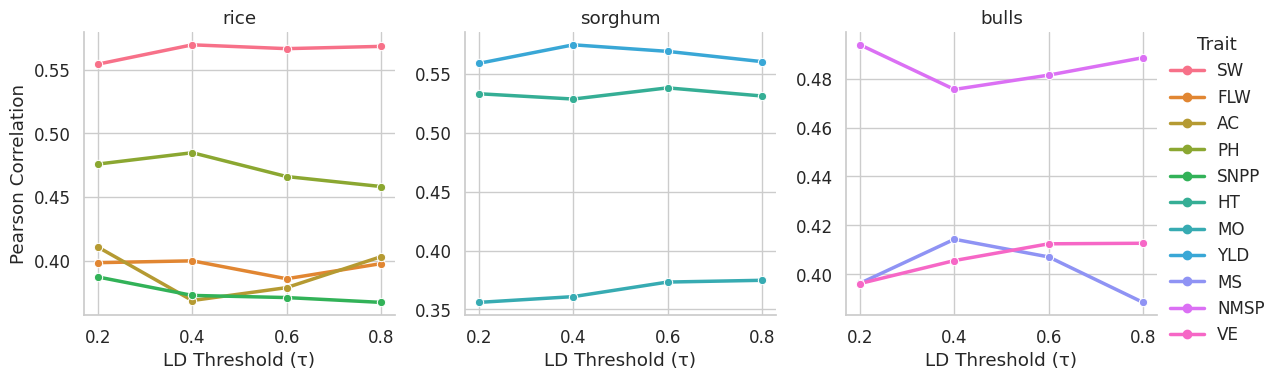

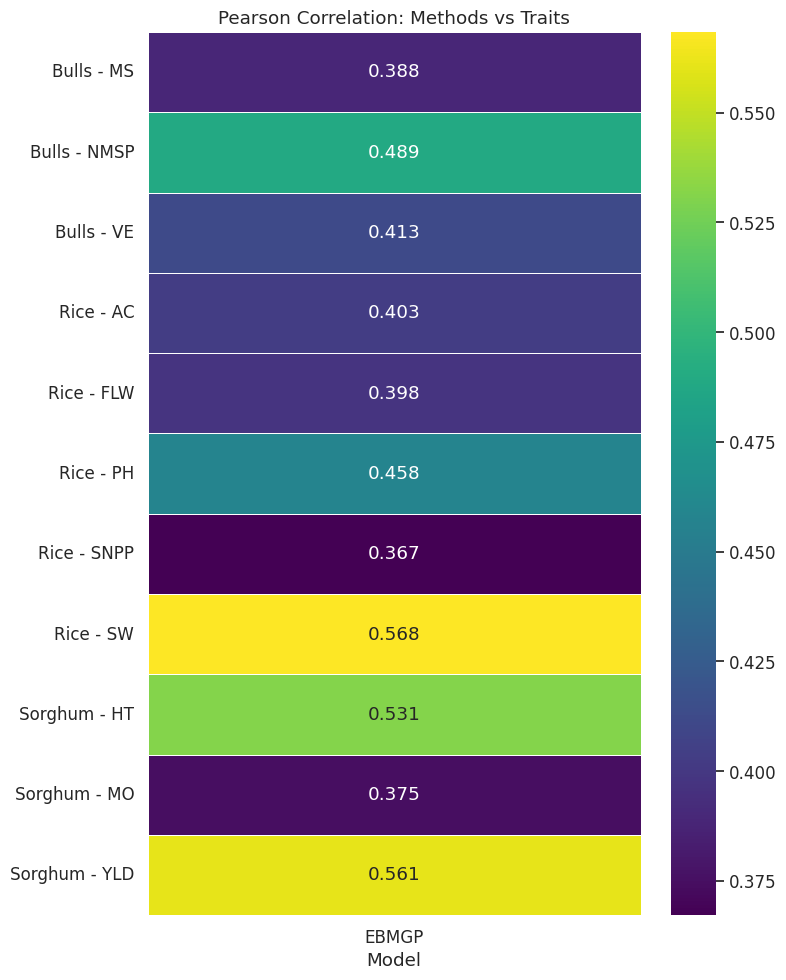

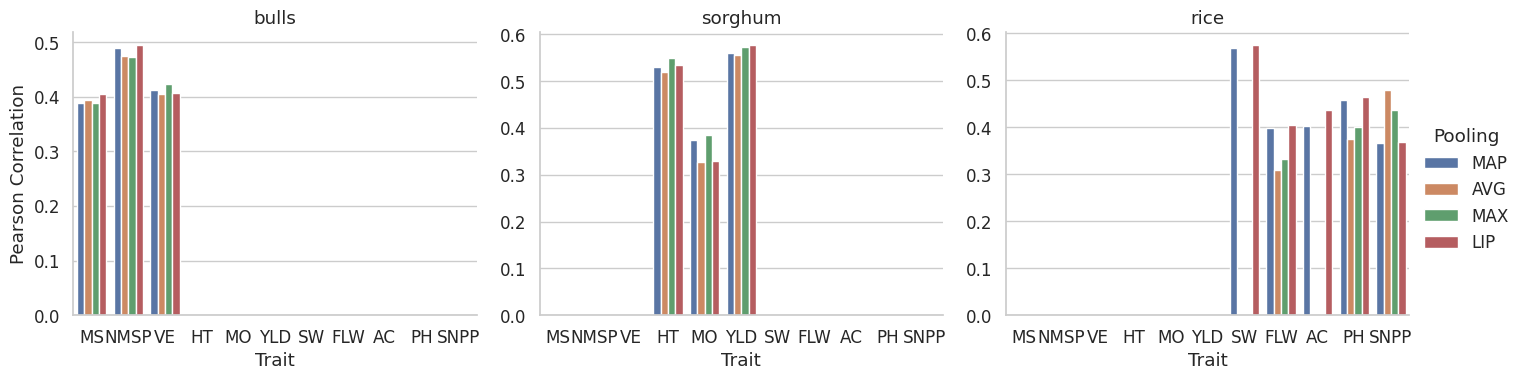

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os

# Set global style
sns.set_theme(style="whitegrid", font_scale=1.1)

def load_results_from_json(pattern):
    """Helper to load all JSONs matching a pattern into a DataFrame"""
    data = []
    files = glob.glob(pattern)
    for f in files:
        with open(f, 'r') as file:
            content = json.load(file)
            # Flatten the 'mean_corrs' dict into rows
            for trait, score in content.get('mean_corrs', {}).items():
                row = content.copy()
                del row['mean_corrs'] # remove dict
                if 'mean_RMSE' in row: del row['mean_RMSE']
                row['Trait'] = trait
                row['Pearson_Corr'] = score
                data.append(row)
    return pd.DataFrame(data)

# ---------------------------------------------------------
# 1. LD Ablation Curves (Line Plot)
# ---------------------------------------------------------
print("Generating LD Ablation Curves...")
df_ld = load_results_from_json("*_LD*.json")

if not df_ld.empty:
    # Filter for MAP pooling if mixed
    if 'pooling_type' in df_ld.columns:
        df_ld = df_ld[df_ld['pooling_type'] == 'MAP']
    
    g = sns.relplot(
        data=df_ld, 
        x="ld_threshold", y="Pearson_Corr", 
        hue="Trait", col="species", 
        kind="line", marker="o", linewidth=2.5,
        height=4, aspect=1, facet_kws={'sharey': False}
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("LD Threshold (τ)", "Pearson Correlation")
    plt.savefig("LD_Ablation_Curves.png", dpi=300, bbox_inches='tight')
    print("Saved: LD_Ablation_Curves.png")
else:
    print("No LD ablation JSON files found.")

# ---------------------------------------------------------
# 2. Benchmark Heatmap (Method x Trait)
# ---------------------------------------------------------
print("\nGenerating Benchmark Heatmap...")
# Load EBMGP results (assuming LD0.8 MAP is the standard EBMGP)
df_ebmgp = load_results_from_json("*_LD0.8.json")
if not df_ebmgp.empty:
    df_ebmgp['Model'] = 'EBMGP'
    df_ebmgp = df_ebmgp[['species', 'Trait', 'Model', 'Pearson_Corr']]

# Load Benchmark results
df_bench = load_results_from_json("*_GBLUP.json") 
df_bench = pd.concat([df_bench, load_results_from_json("*_BayesB.json")])
df_bench = pd.concat([df_bench, load_results_from_json("*_LightGBM.json")])

if not df_bench.empty and not df_ebmgp.empty:
    df_final = pd.concat([df_ebmgp, df_bench], ignore_index=True)
    
    # Create a pivot table for the heatmap
    # Pivot: Index=Trait(Species), Columns=Model, Values=Corr
    df_final['Label'] = df_final['species'].str.capitalize() + " - " + df_final['Trait']
    pivot_df = df_final.pivot_table(index='Label', columns='Model', values='Pearson_Corr')
    
    plt.figure(figsize=(8, 10))
    sns.heatmap(pivot_df, annot=True, cmap="viridis", fmt=".3f", linewidths=.5)
    plt.title("Pearson Correlation: Methods vs Traits")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig("Benchmark_Heatmap.png", dpi=300)
    print("Saved: Benchmark_Heatmap.png")

# ---------------------------------------------------------
# 3. Pooling Comparison (Bar Chart)
# ---------------------------------------------------------
print("\nGenerating Pooling Comparison...")
# We look for files that look like species_T5000_TYPE.json where TYPE is MAP, AVG, etc.
# Note: Reuse logic from run_pooling_ablation naming convention
df_pool = pd.DataFrame()
for p_type in ["MAP", "AVG", "MAX", "LIP"]:
    temp = load_results_from_json(f"*_{p_type}.json")
    temp['Pooling'] = p_type
    df_pool = pd.concat([df_pool, temp])

if not df_pool.empty:
    g = sns.catplot(
        data=df_pool, 
        x="Trait", y="Pearson_Corr", hue="Pooling", col="species",
        kind="bar", height=4, aspect=1.2, sharey=False
    )
    g.set_axis_labels("Trait", "Pearson Correlation")
    g.set_titles("{col_name}")
    plt.savefig("Pooling_Comparison_Bar.png", dpi=300, bbox_inches='tight')
    print("Saved: Pooling_Comparison_Bar.png")

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

# --- FIX SECTION START ---
# REDEFINED evaluate_epoch to handle batches with token_type_ids
def evaluate_epoch(model, loader, loss_fn, metric_fn, device):
    model.eval()
    running_loss = 0.0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in loader:
            # Move all tensors in the batch to the device
            batch = [t.to(device) for t in batch]
            
            # HANDLE BATCH UNPACKING
            if len(batch) == 3:
                # Case: [input_ids, token_type_ids, labels]
                b_input_ids, b_token_types, b_labels = batch
                outputs = model(b_input_ids, token_type_ids=b_token_types)
                target = b_labels
            elif len(batch) == 2:
                # Case: [input_ids, labels] - Attempt to generate dummy types or pass single
                b_input_ids, b_labels = batch
                target = b_labels
                try:
                    outputs = model(b_input_ids)
                except TypeError:
                    # If model strictly demands token_type_ids but loader didn't give them,
                    # generate zeros (common for single-sequence BERT models)
                    b_token_types = torch.zeros_like(b_input_ids, dtype=torch.long)
                    outputs = model(b_input_ids, token_type_ids=b_token_types)
            else:
                raise ValueError(f"Unexpected batch size: {len(batch)}")

            # Compute loss
            loss = loss_fn(outputs, target)
            running_loss += loss.item()
            
            # Store raw tensors
            all_preds.append(outputs)
            all_targets.append(target)

    # Concatenate lists into single Tensors immediately
    if len(all_preds) > 0:
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
    else:
        all_preds = torch.tensor([], device=device)
        all_targets = torch.tensor([], device=device)
    
    return running_loss / len(loader), all_preds, all_targets
# --- FIX SECTION END ---


# Configuration for the "Hero" plots
hero_plots = [
    {"species": "rice", "trait": "SW", "seed": 0},
    {"species": "sorghum", "trait": "YLD", "seed": 0},
    {"species": "bulls", "trait": "NMSP", "seed": 0}
]

for item in hero_plots:
    sp = item['species']
    tr = item['trait']
    sd = item['seed']
    
    print(f"Generating Diagnostics for {sp} - {tr}...")
    
    t_folder = "T5000" 
    data_path = f"./EN/{sp}/{t_folder}{tr}"
    
    config = species_config[sp]
    trait_idx = config['traits'].index(tr)
    
    if not os.path.exists(f"{data_path}{sd}.csv"):
        print(f"Skipping {sp}-{tr}: File {data_path}{sd}.csv not found.")
        continue

    # RUN TRAINING
    # This will now use the IMPROVED evaluate_epoch above
    corr, history, preds, targets = train_and_evaluate(
        trait_idx=trait_idx,
        species=sp,
        data_path=data_path,
        label_path=config["label_path"],
        geno_path=config["geno_path"],
        device=device,
        learning_rate=0.0005,
        epochs=100,
        seed=sd,
        sel_num=5000,
        ld_threshold=0.8,
        pooling_type="MAP"
    )
    
    # --- PLOTTING DATA PREP ---
    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
    elif isinstance(preds, list):
        preds = torch.cat(preds).detach().cpu().numpy()
        targets = torch.cat(targets).detach().cpu().numpy()
        
    preds = preds.flatten()
    targets = targets.flatten()
    # --------------------------
    
    # 1. Plot Loss Curve
    plt.figure(figsize=(6, 4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f"Training Convergence: {sp.capitalize()} {tr}")
    plt.xlabel("Epoch")
    plt.ylabel("L1 Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    loss_filename = f"{sp}_{tr}_loss_curve.png"
    plt.savefig(loss_filename, dpi=300)
    plt.close()
    print(f"   Saved {loss_filename}")
    
    # 2. Plot Scatter (Pred vs Obs)
    plt.figure(figsize=(5, 5))
    
    d_min = min(np.min(preds), np.min(targets))
    d_max = max(np.max(preds), np.max(targets))
    pad = (d_max - d_min) * 0.1
    
    plt.scatter(targets, preds, alpha=0.6, edgecolors='w', s=50)
    plt.plot([d_min-pad, d_max+pad], [d_min-pad, d_max+pad], 'r--', label="Perfect Fit")
    
    plt.title(f"{sp.capitalize()} {tr} (r={corr:.3f})")
    plt.xlabel("Observed Phenotype (Standardized)")
    plt.ylabel("Predicted Phenotype")
    plt.xlim(d_min-pad, d_max+pad)
    plt.ylim(d_min-pad, d_max+pad)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    scat_filename = f"{sp}_{tr}_scatter.png"
    plt.savefig(scat_filename, dpi=300)
    plt.close()
    print(f"   Saved {scat_filename}")

Generating Diagnostics for rice - SW...
   Epoch 10/100 | Train Loss: 0.6724 | Val Loss: 0.6198 | Val Corr: 0.6238
   Epoch 20/100 | Train Loss: 0.5759 | Val Loss: 0.5259 | Val Corr: 0.6747
   Epoch 30/100 | Train Loss: 0.5152 | Val Loss: 0.5731 | Val Corr: 0.6571
   Epoch 40/100 | Train Loss: 0.4526 | Val Loss: 0.5335 | Val Corr: 0.6465
   Epoch 50/100 | Train Loss: 0.4180 | Val Loss: 0.5733 | Val Corr: 0.6150
   Epoch 60/100 | Train Loss: 0.4071 | Val Loss: 0.6127 | Val Corr: 0.6118
   Epoch 70/100 | Train Loss: 0.3965 | Val Loss: 0.5773 | Val Corr: 0.6114
   Epoch 80/100 | Train Loss: 0.3845 | Val Loss: 0.5386 | Val Corr: 0.6174
   Epoch 90/100 | Train Loss: 0.3982 | Val Loss: 0.5685 | Val Corr: 0.6264
   Epoch 100/100 | Train Loss: 0.3809 | Val Loss: 0.5285 | Val Corr: 0.6238
Finished. Final Test Correlation: 0.6238
   Saved rice_SW_loss_curve.png
   Saved rice_SW_scatter.png
Generating Diagnostics for sorghum - YLD...
   Epoch 10/100 | Train Loss: 0.5679 | Val Loss: 0.6775 | Val C

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

# Define the specific traits you listed in the LaTeX images section
target_plots = [
    ("rice", "AC"),
    ("rice", "FLW"),
    ("rice", "PH"),
    ("rice", "SNPP"),
    ("rice", "SW")
]

print("Generating Manhattan Plots...")

for species, trait in target_plots:
    # Construct pattern to find the file (e.g., ./EN/rice/T5000AC0.csv)
    # Using T5000 as default based on your text
    file_pattern = f"./EN/{species}/T5000{trait}0.csv" 
    
    files = glob.glob(file_pattern)
    if not files:
        print(f"  [Warning] No file found for {species} - {trait}")
        continue
        
    # Use the first seed (0) found
    filepath = files[0]
    
    try:
        df = pd.read_csv(filepath)
        
        plt.figure(figsize=(10, 4))
        # 'index' is the SNP location, 'cs' is the Elastic Net absolute coefficient
        plt.scatter(df['index'], df['cs'], c='navy', alpha=0.6, s=15, edgecolors='none')
        
        plt.title(f"Feature Importance (Elastic Net): {species.capitalize()} - {trait}")
        plt.xlabel("SNP Index")
        plt.ylabel("Selection Score (Abs Coeff)")
        
        # Add a baseline threshold line for visual context
        plt.axhline(y=0, color='grey', linewidth=0.5)
        
        plt.tight_layout()
        
        out_name = f"{species}_{trait}_manhattan.png"
        plt.savefig(out_name, dpi=300)
        plt.close()
        print(f"  Saved {out_name}")
        
    except Exception as e:
        print(f"  Error plotting {species}-{trait}: {e}")

Generating Manhattan Plots...
  Saved rice_AC_manhattan.png
  Saved rice_FLW_manhattan.png
  Saved rice_PH_manhattan.png
  Saved rice_SNPP_manhattan.png
  Saved rice_SW_manhattan.png
